In [1]:
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy as np

%matplotlib inline
from sklearn.linear_model import LinearRegression


datapath="/home/felix/spiced/03_week/data/"

In [2]:
df_train = pd.read_csv(datapath+'bike_train.csv', parse_dates=True, index_col=0)
df_test  = pd.read_csv(datapath+'bike_test.csv', parse_dates=True, index_col=0)

In [3]:
def preprocess(df):
    df["weather"].replace(4,3, inplace=True)
    df["hour"]=[i.hour for i in df.index]
    df["year"]=[i.year for i in df.index]
    df["month"]=np.array([ind.month+(ind.year-2011)*12 for ind in df.index])
    
    df["atemp_sc"]     =(df["atemp"]    - df["atemp"].mean()) /     df["atemp"].std()
    df["windspeed_sc"] =(df["windspeed"]- df["atemp"].mean()) / df["windspeed"].std()    
    df=df.drop("atemp", axis=1)
    df=df.drop("windspeed", axis=1)
    df=df.drop("humidity", axis=1)
    df=df.drop("holiday", axis=1)
    df=df.drop("temp", axis=1)
    
    df.sort_index(inplace=True)
    return df

dftrain=preprocess(df_train)
dftest=preprocess(df_test)

dftrain.drop("casual", axis=1, inplace=True)
dftrain.drop("registered", axis=1, inplace=True)

In [4]:
df_train_out = pd.DataFrame()
df_test_out  = pd.DataFrame()

for hour in range(24):
    for workingday in [0,1]:


        featureset=['season','year','month','weather',  'atemp_sc','windspeed_sc']
        selectionset=((dftrain["workingday"]==workingday)*(dftrain["hour"]==hour))

        df_wd=dftrain[selectionset]
        Xtrain=df_wd[featureset]
        Ytrain=df_wd["count"]

        selectionset=((dftest["workingday"]==workingday)*(dftest["hour"]==hour))
        df_wd2=dftest[selectionset]
        Xtest=df_wd2[featureset]

        m=LinearRegression()
        m.fit(Xtrain,Ytrain)

        Ytrainpred=m.predict(Xtrain)
        Ytrainpred=np.round(Ytrainpred).astype(int)
        Ytrainpred[Ytrainpred<0]=0

        Ytestpred=m.predict(Xtest)
        Ytestpred=np.round(Ytestpred).astype(int)
        Ytestpred[Ytestpred<0]=0

        
        
        XYtrain=Xtrain.join(Ytrain)
        XYtrain["Ypred"]=Ytrainpred
        df_train_out=pd.concat([df_train_out, XYtrain])

        XYtest=Xtest.copy()
        XYtest["Ypred"]=Ytestpred
        df_test_out=pd.concat([df_test_out, XYtest])

        
        
df_train_out.sort_index(inplace=True)
df_test_out.sort_index(inplace=True)

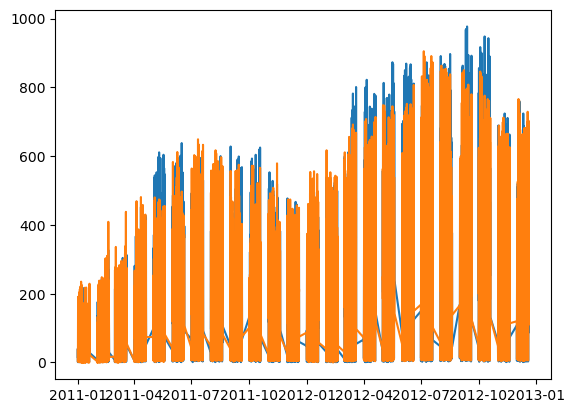

In [5]:
plt.plot(df_train_out.index, df_train_out["count"])
plt.plot(df_train_out.index, df_train_out["Ypred"])

In [6]:
from sklearn.metrics import accuracy_score, r2_score

print(accuracy_score(df_train_out["count"], df_train_out["Ypred"]))
print(r2_score(df_train_out["count"], df_train_out["Ypred"]))

from sklearn.metrics import mean_squared_log_error

kaggle_score_train = np.sqrt(mean_squared_log_error(y_true=df_train_out["count"], y_pred=df_train_out["Ypred"]))
print(kaggle_score_train)




0.02884438728642293
0.9092434875130362
0.4304740352323907


In [7]:
kaggel_df=pd.DataFrame(df_test_out["Ypred"].to_numpy(), index=df_test_out.index, columns=["count"])

In [8]:
kaggel_df.to_csv("bike_share_kaggle.csv")